<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/module_12/%D0%94%D0%B5%D0%BC%D0%BE_2D_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple GAN

В этом уроке мы с вами создадим первую генеративную модель с помощью Keras. 

Поставим пред собой задачу научить алгоритм генерировать данные из известного нам распределения синтетических данных. Мы будем сначала работать с очень простыми данными -- чтобы понять механику обучения таких сетей. Как только мы справимся с этим -- то сможем перейти к генерации изображений.

In [2]:
import tensorflow as tf
#tf.enable_eager_execution()

Начнем с простой квадратичной зависимости:

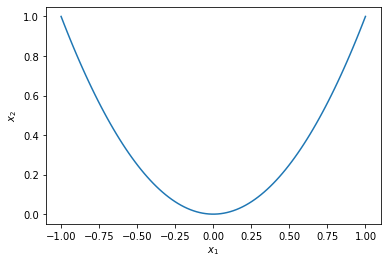

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def real_f(x):
    return x * x

plt.plot(np.linspace(-1, 1, 100), real_f(np.linspace(-1, 1, 100)))
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")
plt.show()

Сэмплировать из реального распределения можно следующим образом: сначала сэмплируем $x_1$, затем возводим его в квадрат и получаем $x_2$.

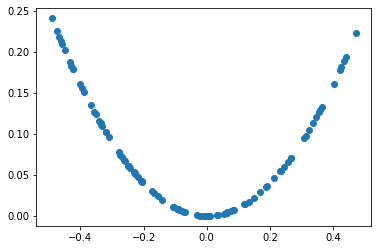

In [4]:
def generate_real_samples(n=100):
    """
    Функция сэмплирует данные из реального распределения.
    """
    x = np.random.rand(n) - 0.5
    y = real_f(x)
    return np.vstack((x, y)).T

real_data = generate_real_samples(n=100)
plt.scatter(real_data[:, 0], real_data[:, 1])

Это кажется похожим на задачу регрессии. Но она гораздо сложнее. В регрессии мы "знаем" чего мы хотим от алгороитма -- чтобы точки были близки по эвклидовому расстоянию к исходным. Но это потому что задача очень простая и мы знаем что "хорошо", а что плохо. 

А в общем случае мы ее не знаем! Мы увидите ниже, что мы не используем нигда MSE лосс, который здесь так напрашивается, и при этом получаем очень близкие результаты. 

## Дискриминатор
А сейчас мы определим дискриминатор. Т.е. ту часть GAN, которая должна уметь отличать реальные сэмплы от нереальных. Для начала мы обучим его отличать реальные данные от случайно сгенерированных, и лишь потом мы усложним ему задачу добавим "умного" соперника.

На вход она должна принимать объект (в нашем случае это точка с двумя координатами), а возвращать логит того, что это точка из реального распределения.

In [5]:
def build_discriminator(n_inputs=2):
	model = tf.keras.models.Sequential()
	model.add(tf.keras.layers.Dense(10, activation='relu', input_dim=n_inputs))
	model.add(tf.keras.layers.Dense(10, activation='relu'))
	model.add(tf.keras.layers.Dense(1))
	return model
 
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


Для обучения дискриминатора мы должны также уметь генерировать фейковые данные. Позже это будет делать генератор (еще одна сеть), но пока нам хватит генератора случайных чисел.

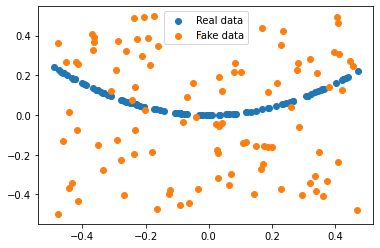

In [6]:
def generate_fake_samples(n):
	x = np.random.rand(n) - 0.5
	y = np.random.rand(n) - 0.5
	return np.vstack((x, y)).T

fake_data = generate_fake_samples(100)
# отличить такие данные очень просто:
plt.scatter(real_data[:, 0], real_data[:, 1], label="Real data")
plt.scatter(fake_data[:, 0], fake_data[:, 1], label="Fake data")
plt.legend(loc="best")

# Лосс дискриминатора

При обучении дискриминатора мы будем подавать ему половину батча из реальных сэмплов, а половину их фейковых. Его задача предсказать "класс 1" -- реальные данные для реальной половины и "класс 0" -- фейковые, для нереальных. Теперь запишем это с помощью функии: 

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_pred_real_data, disc_pred_fake_data):
    """
    disc_pred_real_data -- логиты, предсказанные дискриминатором для реальных данных
    disc_pred_fake_data -- логиты, предсказанные дискриминатором для фейковых данных
    """
    real_labels = tf.ones_like(disc_pred_real_data) # правильные ответ для реальных данных -- 1
    fake_labels = tf.zeros_like(disc_pred_fake_data) # правильные ответ для фейковых данных -- 0
    
    real_loss = cross_entropy(real_labels, disc_pred_real_data)
    fake_loss = cross_entropy(fake_labels, disc_pred_fake_data)

    total_loss = real_loss + fake_loss
    return total_loss

## Цикл обучения

Мы реализуем цикл обучения "вручную". Начнем с функции описывающую шаг обучения для одного батча. В ней мы должны:
1.  сгенерировать половину батча реальных данных и половину фейковых
2.  после этого посчитать выходы дискриминатора для обеих частей
3.  затем посчитать лосс и обновить веса с помощью оптимизатора.

In [8]:
from sklearn.metrics import accuracy_score

def train_step(discriminator, optimizer, batch_size=128):
    half_batch = int(batch_size / 2)	
    with tf.GradientTape() as disc_tape: # записываем градиенты на "ленту"
        X_real = generate_real_samples(n=half_batch) # генерируем реальные сэмплы
        X_fake = generate_fake_samples(n=half_batch) # генерируем фейковые сэмплы
        
        real_output = discriminator(X_real)
        fake_output = discriminator(X_fake)
        
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # dL/dDiscr
    optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Обновление весов дискриминатора
    
    acc_real = accuracy_score(discriminator(X_real).numpy() > 0, np.ones(half_batch))
    acc_fake = accuracy_score(discriminator(X_fake).numpy() > 0, np.zeros(half_batch))
    return acc_real, acc_fake
		

In [9]:
from tqdm import tqdm_notebook as tqdm
def train_discriminator(discriminator, optimizer, n_epochs=1000, n_batch=128):
	acc_real_logs = []
	acc_fake_logs = []
	for i in tqdm(range(n_epochs)):
		acc_real, acc_fake = train_step(discriminator, optimizer, n_batch)
		acc_real_logs.append(acc_real)
		acc_fake_logs.append(acc_fake)
	return acc_real_logs, acc_fake_logs

In [10]:
discriminator = build_discriminator()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
acc_real_logs, acc_fake_logs = train_discriminator(discriminator, optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/1000 [00:00<?, ?it/s]

Можно увидеть ниже, что дискриминатор c этой частью задания справился неплохо. Но без обучаемого генератора, мы не решаем нашу основную задачу -- генерация данных их исходного распределения. 


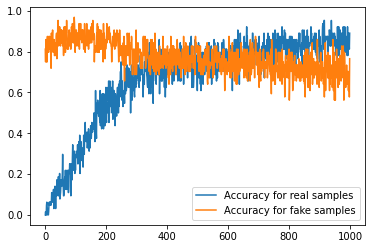

In [11]:
plt.plot(acc_real_logs, label="Accuracy for real samples")
plt.plot(acc_fake_logs, label="Accuracy for fake samples")
plt.legend(loc="best")

# Генератор

Перейдем к определению генератора. Генератор принимает на вход вектор размера latent_dim -- т.е. размерность скрытого пространства, а выдает вектор размерности наших данных -- т.е. 2. В нашем случае мы будем использовать latent_dim=5 (выбрано произвольно). Т.е. задача генератора превращать случаные вектора длины 5 в вектора длины 2.

In [12]:
def build_generator(latent_dim, n_outputs=2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(15, activation='relu', input_dim=latent_dim))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs))
    return model
 
# define the discriminator model
generator = build_generator(5)
# summarize the model
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 15)                90        
                                                                 
 dense_7 (Dense)             (None, 10)                160       
                                                                 
 dense_8 (Dense)             (None, 2)                 22        
                                                                 
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________


In [13]:
def generate_latent_points(latent_dim, n):
	x_input = np.random.randn(n,  latent_dim)
	return x_input

In [14]:
random_vectors = generate_latent_points(latent_dim=5, n=3)
print("Случайные вектора размера 5:", random_vectors)

Случайные вектора размера 5: [[ 0.88764446 -0.13874403  2.31477808 -0.6976944   1.71449099]
 [-2.23423012  0.80056998 -1.47457346  0.96251296  0.12224644]
 [ 0.48707529 -0.2365754   1.25423065 -1.3117565  -0.09897621]]


In [15]:
generator(random_vectors).numpy() # генератор превратил их в векторы длины 2

array([[ 0.63967216,  0.30390772],
       [ 1.4538641 , -0.23623002],
       [ 0.81509066,  0.26202875]], dtype=float32)

In [16]:
def generate_fake_samples(generator, n):
    x_input = generate_latent_points(generator.input_shape[1], n)
    X = generator.predict(x_input)
    return X

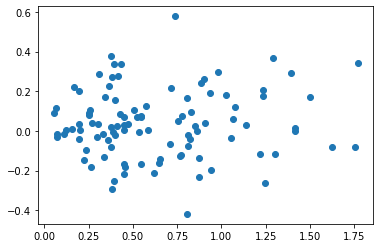

In [17]:
X = generate_fake_samples(generator, n=100)
plt.scatter(X[:, 0], X[:, 1])

# Лосс генератора

Лосс функция генератора принимает маленькие значения, если дискриминатор много ошибается на примерах, которые сгенерировал генератор (т.е. когда у него получается обмануть его). И наоборот -- большие, если дискриминатор идально справился со своей задачей. 

На вход лосс функция генератора принимает выходы дискриминатора на фейковых данных.

In [19]:
def generator_loss(discr_pred_fake_data):
    """
    discr_pred_fake_data -- предсказания дискриминатора на фейковых данных
    """
    labels = tf.ones_like(discr_pred_fake_data)
    # для генератора "хорошо", 
    # когда фейковые данные дискриминатор назвал реальными
    return cross_entropy(labels, discr_pred_fake_data) 

# Собираем все вместе

Теперь мы можем повторить подход описанный на лекции! Для начала реализуем как и выше train_step. В нем мы должны:
1. Сэмплировать $\text{batch_size}/2$ точек из реального распределения (`x_real`)
2. Сгенерировать $\text{batch_size}/2$ точек с помощью текущей версии генератора (`x_fake`)
3. Сделать `forward_pass` дискриминатора на `x_real` и `x_fake`, получив `discr_pred_real_data` и `discr_pred_fake_data`.
4. Посчитать лосс дискриминатора и генератора
5. Обновить параметры генератора и дискриминатора. Они оба должны теперь "научиться" на своих ошибках -- дискриминатор должен различать данные еще лучше, а генератор должен генерировать более правдоподобные выборки.


In [20]:
def train_step(discriminator, generator, optimizer, batch_size=128):
    half_batch = int(batch_size / 2)	
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 1. Сэмплируем batch_size/2 точек из реального распределения
        X_real = generate_real_samples(n=half_batch)
        
        # генератор генерирует данные из латентных векторов, которые принадлежат простому распределению
        # и учится превращать их в распределени которое сможет обмануть дискриминатор
        # сначала генерируем латентные вектора -- 
        latent_z = np.random.randn(half_batch,  generator.input_shape[1])
        # а затем превращаем их с помощью генератора в X_fake
        X_fake = generator(latent_z)
        
        # 3. Делаем forward_pass дискриминатора на x_real и x_fake, 
        # получив discr_pred_real_data и discr_pred_fake_data
        discr_pred_real_data = discriminator(X_real)
        discr_pred_fake_data = discriminator(X_fake)

        # 4. Посчитать лосс дискриминатора и генератора
        disc_loss = discriminator_loss(discr_pred_real_data, discr_pred_fake_data)
        gen_loss = generator_loss(discr_pred_fake_data)
    
    # считаем производные
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # 5. Обновляем параметры генератора и дискриминатора. 
    optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return disc_loss.numpy(), gen_loss.numpy()

In [21]:
def show_result(generator, title=""):
    X_fake = generate_fake_samples(generator=generator, n=100)
    X_real = generate_real_samples(n=100)  
    plt.figure()
    plt.title(title)
    plt.scatter(X_real[:, 0], X_real[:, 1], label="real samples")
    plt.scatter(X_fake[:, 0], X_fake[:, 1], label="generated samples")
    plt.legend(loc="best")
    plt.show()


In [22]:
def train_gan(discriminator, generator, optimizer, n_epochs=10000, n_batch=128,
              show_every=1000):
    losses_hist_disc = []
    losses_hist_gen = []
    for i in tqdm(range(n_epochs)):
        if i % show_every == 0:
            show_result(generator=generator, title=f"Epoch {i}")
            
        disc_loss, gen_loss = train_step(discriminator, generator, optimizer, n_batch)
        losses_hist_disc.append(disc_loss)
        losses_hist_gen.append(gen_loss)
    return losses_hist_disc, losses_hist_gen

## Переходим к обучению

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/10000 [00:00<?, ?it/s]

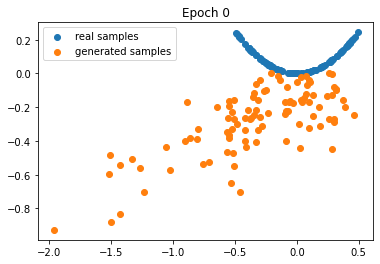

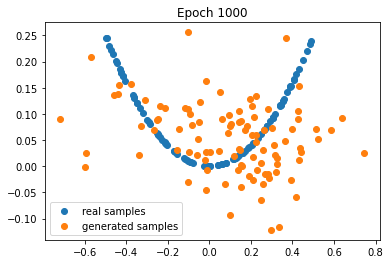

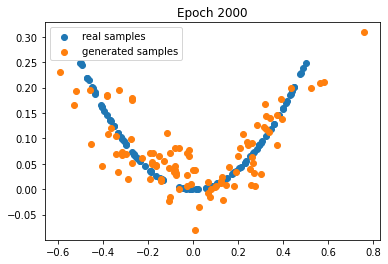

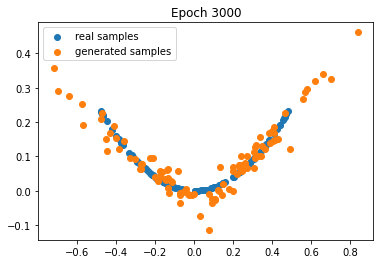

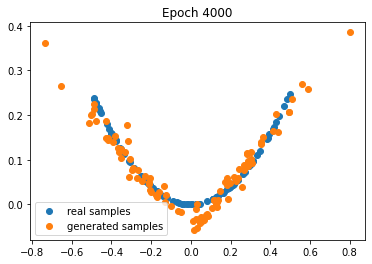

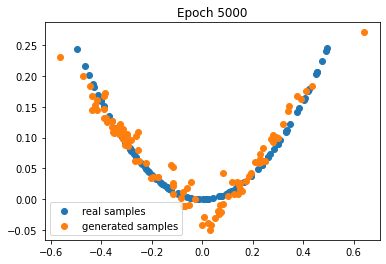

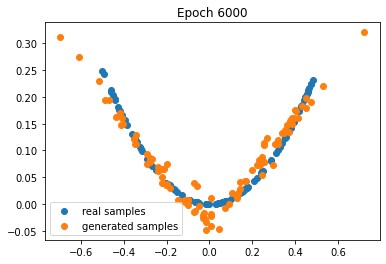

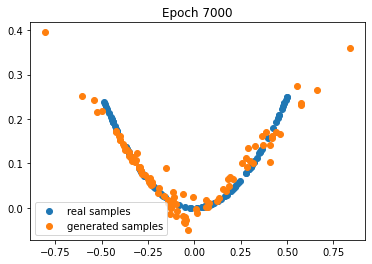

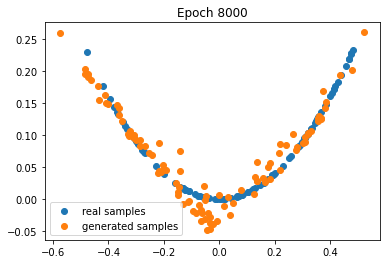

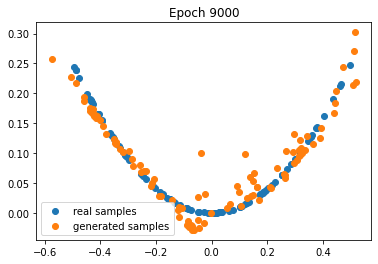

In [23]:
generator = build_generator(latent_dim=5, n_outputs=2)
discriminator = build_discriminator(n_inputs=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

losses_hist_disc, losses_hist_gen = train_gan(discriminator, generator, optimizer, n_epochs=10000,
                                              show_every=1000)    

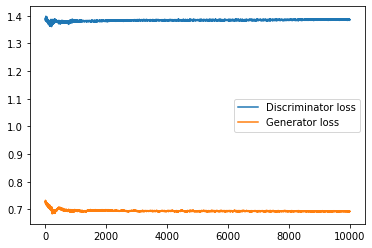

In [24]:
plt.plot(losses_hist_disc, label="Discriminator loss")
plt.plot(losses_hist_gen, label="Generator loss")
plt.legend(loc="best")

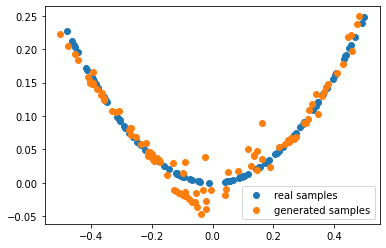

In [25]:
show_result(generator=generator)

Ура! Мы обучили генератор данных. Именно эта часть GAN представляет интерес. 

Обращаю внимание на неочевидный но очень важный факт. Вам может показаться что мы ничего особенного не сделали. Это было похоже на задачу регрессии, а такие кривые мы умеем запросто приближать, зачем тогда нужно было так усложнять задачу?

Ответ кроется в том, что это для такой простой задачи нам очевидно, что данные, которые находятся близко согласно евклидовому расстоянию к исходным -- правильные. Поэтому мы могли просто сформулировать задачу обучения для регрессии. Но в общем случае нам не известно какая функция нас приведет к генерации правильных данных! Т.е. мы перекладываем на дискриминатор ответственность за качество сгенерированных сэмплов, а он может "придумать" любую функцию лишь бы справиться со своей задачей.


# Заключение

В этом уроке мы подробно разобрали реализацию GAN с помощью Tensorflow. Увидели своими глазами как данные из абсолютно случайных и непредсказуемых приобретают запрошенную форму. При этом (это очень важно!!), мы не говорили алгоритму что "хорошо" это когда данные близко к исходным. У нас нет нигде в коде MSE лосса. 

Применение такого подхода к обучению становится еще интереснее когда дело доходит до изображений. Как работать с ними -- мы узнаем в следующем уроке. А сейчас мы предлагаем вам еще попрактиковаться с двумерными данными.